In [4]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [129]:
db1__catch = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/catch.csv", parse_dates=['date'])
db1__product = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/product.csv", parse_dates=['date'])
db1__fish = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/fish.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__prod_designate = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/prod_designate.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__prod_type = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/prod_type.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__regime = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/regime.csv", encoding='utf8', on_bad_lines='skip', sep=';')
db1__region = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db1/ref/region.csv", encoding='utf8', on_bad_lines='skip', sep=';')

db2__ext = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db2/Ext.csv", encoding='utf8', parse_dates=['date_fishery', 'Product_period'])
db2__ext2 = pd.read_csv("D:/AI__2022/Хакатоны/2022/27-28.05__Дальневосточный/data/Датасет/db2/Ext2.csv", encoding='utf8', parse_dates=['date_vsd'])

In [130]:
db1__catch.name = 'db1__catch'
db1__product.name = 'db1__product'
db1__fish.name = 'db1__fish'
db1__prod_designate.name = 'db1__prod_designate'
db1__prod_type.name = 'db1__prod_type'
db1__regime.name = 'db1__regime'
db1__region.name = 'db1__region'
db2__ext.name = 'db2__ext'
db2__ext2.name = 'db2__ext2'



datasets = {'db1__catch':db1__catch,
            'db1__product':db1__product,
            'db1__fish':db1__fish,
            'db1__prod_designate':db1__prod_designate,
            'db1__prod_type':db1__prod_type,
            'db1__regime':db1__regime,
            'db1__region':db1__region,
            'db2__ext':db2__ext,
            'db2__ext2':db2__ext2
            }

    
def general_information (dataset):
    
    total_na = dataset.isna().sum().sort_values(ascending = False)
    percent_of_na = (dataset.isna().sum() * 100 / dataset.isna().count()).sort_values(ascending=False)
    missing_dataset = pd.concat([total_na, percent_of_na], axis = 1, keys = ['Missing values quantity', '%_of missing values'])
    for index in missing_dataset.index:
        missing_dataset.loc[index, 'Unique values quantity'] = dataset[index].value_counts().count()
    missing_dataset['Unique values quantity'] = missing_dataset['Unique values quantity'].astype('int64')
    missing_dataset['Data type'] = dataset[missing_dataset.index].dtypes
    missing_dataset.index.name = 'Feature'

    print('\033[92m', '\033[4m', 'Dataset {} consist of {} objects and {} features'.
        format('" '+dataset.name+' "', len(dataset), len(dataset.columns)), '\033[0m', end='\n\n')

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        print(missing_dataset.to_string(), end='\n\n')


for k, v in datasets.items():
    general_information(v)

  Dataset " db1__catch " consist of 85087 objects and 8 features 

              Missing values quantity  %_of missing values  Unique values quantity       Data type
Feature                                                                                           
id_ves                              0                  0.0                     733           int64
date                                0                  0.0                     110  datetime64[ns]
id_region                           0                  0.0                      50           int64
id_fish                             0                  0.0                     118           int64
catch_volume                        0                  0.0                   30429         float64
id_regime                           0                  0.0                      10           int64
permit                              0                  0.0                    1408           int64
id_own                              0     

In [131]:
for k, v in datasets.items():

    print('The numder of duplicates in dataset """ {} """ is     {}'.format(k, v.duplicated().sum()))

The numder of duplicates in dataset """ db1__catch """ is     0
The numder of duplicates in dataset """ db1__product """ is     0
The numder of duplicates in dataset """ db1__fish """ is     0
The numder of duplicates in dataset """ db1__prod_designate """ is     0
The numder of duplicates in dataset """ db1__prod_type """ is     0
The numder of duplicates in dataset """ db1__regime """ is     0
The numder of duplicates in dataset """ db1__region """ is     0
The numder of duplicates in dataset """ db2__ext """ is     0
The numder of duplicates in dataset """ db2__ext2 """ is     0


In [237]:
db2__ext2[db2__ext2.unit.isin(['\\N'])].volume.describe()

count    6.245200e+04
mean     1.687210e+04
std      4.776406e+04
min      0.000000e+00
25%      2.170000e+02
50%      1.105000e+03
75%      8.747250e+03
max      3.905000e+06
Name: volume, dtype: float64

Переводим кг и \\N в тонны

In [132]:
db2__ext2.loc[db2__ext2.unit.isin(['кг']), 'volume'] = db2__ext2.loc[db2__ext2.unit.isin(['кг']), 'volume'] / 1000
db2__ext2.loc[db2__ext2.unit.isin(['\\N']), 'volume'] = db2__ext2.loc[db2__ext2.unit.isin(['\\N']), 'volume'] / 1000

numPart убираем (всего 0.0003% значимых значений), Name_Plat не нужен, есть id_Plat

In [140]:
db1_main = pd.merge(
pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(db1__catch, db1__product, how='outer', on=['id_ves', 'date']), db1__fish, how='left', on=['id_fish']), db1__prod_designate, how='left', on=['id_prod_designate']), \
db1__prod_type[['id_prod_type', 'prod_type_full']], how='left', on=['id_prod_type']), db1__regime, how='left', on=['id_regime']), db1__region, how='left', on=['id_region']
)


db2_main = pd.merge(db2__ext.drop(columns=['numPart', 'Name_Plat']), db2__ext2.drop(columns=['num_vsd',	'date_vsd', 'unit']), how='inner', on=['id_vsd'])

db1_main = db1_main.drop(columns=['id_region', 'id_fish', 'id_regime', 'permit', 'id_prod_designate', 'id_prod_type'])

db1_main.set_index('date', inplace=True)
db2_main.set_index('date_fishery', inplace=True)

In [141]:
db2_main.shape

(3205586, 9)

Удаляем наблюдения со значением -1 в id_own и id_ves из db2_main

In [150]:
db2_main.drop(db2_main[(db2_main.id_ves < 0) & (db2_main.id_own < 0)].index, inplace=True)

In [151]:
db2_main.shape

(105528, 9)

In [152]:
db2_main.head()

,id_ves,id_own,id_Plat,id_vsd,Product_period,Region_Plat,id_fish,fish,volume
date_fishery,,,,,,,,,
2021-12-30,1315,1200,6292847,6778938,\N,\N,292,треска,6.718
2021-12-31,1478,1177,6296744,8254175,\N,\N,292,треска,41.769
2021-12-31,1478,1177,6296744,9087363,\N,\N,408,пикша,1.442
2021-12-31,1478,1177,6296744,8078978,\N,\N,714,камбала-ерш,0.407
2021-12-31,1453,992,6290070,9329268,\N,\N,859,креветка северная,1.950


In [153]:
db1_main.head()

,id_ves,catch_volume,id_own,prod_volume,prod_board_volume,fish,prod_designate,prod_type_full,regime,region
date,,,,,,,,,,
2022-01-01,1628,31.874,961.0,0.161,4.485,минтай,"рыбопродукция, выпущенная из собственного сырь...",молоки минтая мороженые,на инвестиционные цели (пром),Камчатско-Курильская (СЗТО)
2022-01-01,1292,1.675,1114.0,0.294,0.294,зубатка синяя,"рыбопродукция, выпущенная из собственного сырь...",зубатка пестрая потрошен. обезглав. морожен.1с,разрешенный прилов,Подзона Гренландское море (архипелаг Шпицберген)
2022-01-01,1292,1.675,1114.0,0.190,0.190,зубатка синяя,"рыбопродукция, выпущенная из собственного сырь...","зубатка полосатая, потрошен. без головы морож...",разрешенный прилов,Подзона Гренландское море (архипелаг Шпицберген)
2022-01-01,1292,1.675,1114.0,0.028,0.028,зубатка синяя,"рыбопродукция, выпущенная из собственного сырь...",языки трески мороженые,разрешенный прилов,Подзона Гренландское море (архипелаг Шпицберген)
2022-01-01,1292,1.675,1114.0,0.025,0.025,зубатка синяя,"рыбопродукция, выпущенная из собственного сырь...",пикша мелкая потрошеная без головы мороженая н...,разрешенный прилов,Подзона Гренландское море (архипелаг Шпицберген)


In [155]:
db2_main.fish.nunique()

109

In [156]:
db1_main.fish.nunique()

118

In [ ]:
db2_main.fish.unique()

In [98]:
db2_main[db2_main.id_vsd == 8114408]

,id_ves,id_own,id_Plat,id_vsd,Product_period,Region_Plat,id_fish,volume
date_fishery,,,,,,,,
2022-04-19 00:00:00,1498,1234,6296509,8114408,\N,0,-1,0.000
2022-04-19 00:00:00,1498,1234,6296509,8114408,\N,0,779,0.252
2022-04-20 02:22:57,-1,-1,6296509,8114408,\N,14,-1,0.000
2022-04-20 02:22:57,-1,-1,6296509,8114408,\N,14,779,0.252


In [145]:
db1_main.sort_index(inplace=True)
db2_main.sort_index(inplace=True)
print(db1_main.index.is_monotonic, db2_main.index.is_monotonic)

True True


In [9]:
db1_main['prod_designate'] = pd.factorize(db1_main['prod_designate'])[0]
db1_main['prod_type_full'] = pd.factorize(db1_main['prod_type_full'])[0]
db1_main['regime'] = pd.factorize(db1_main['regime'])[0]
db1_main['region'] = pd.factorize(db1_main['region'])[0]


db2_main['Region_Plat'] = pd.factorize(db2_main['Region_Plat'])[0]

In [10]:
db1_volume = db1_main.resample('1D')['catch_volume'].sum()
db2_volume = db2_main.resample('1D')['volume'].sum()

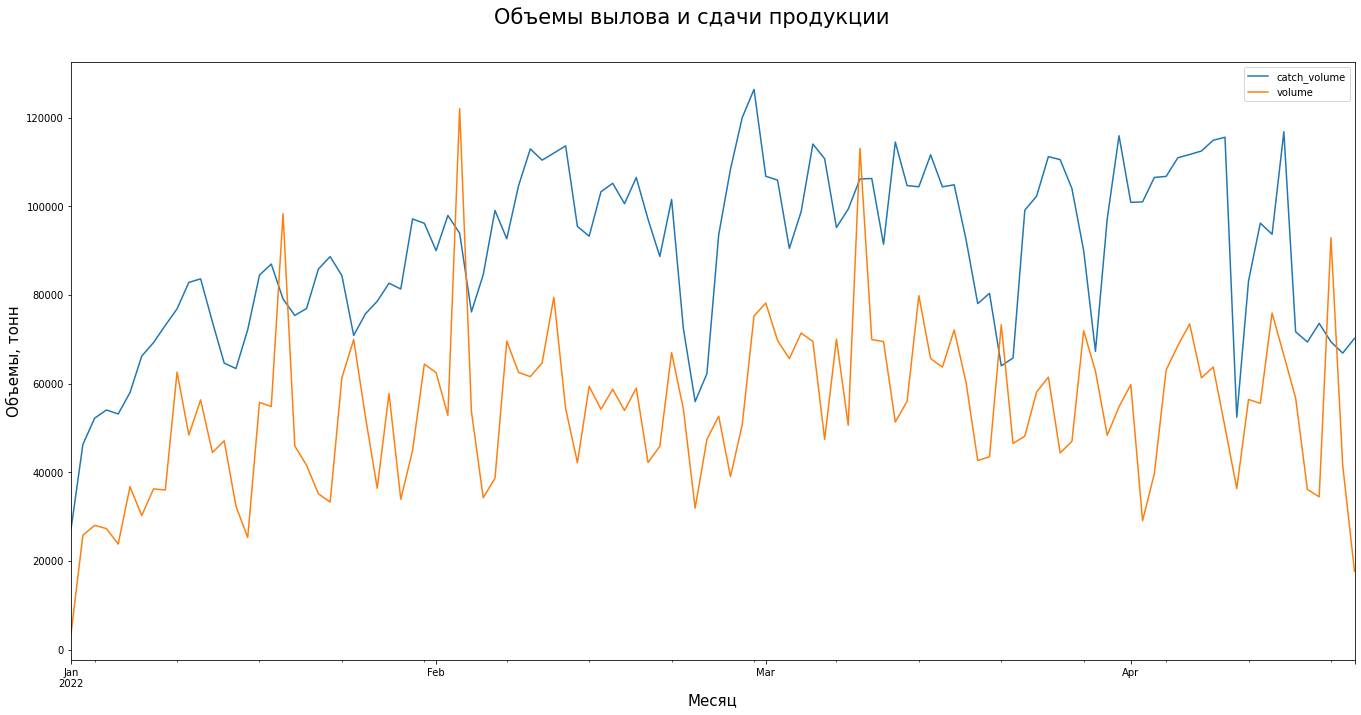

In [11]:
db_volume = pd.merge(db1_volume, db2_volume, how='inner', left_index=True, right_index=True)

db_volume.plot(figsize=(23, 11))
plt.suptitle('Объемы вылова и сдачи продукции', fontsize=21, y=0.95)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Объемы, тонн', fontsize=15)
plt.show()

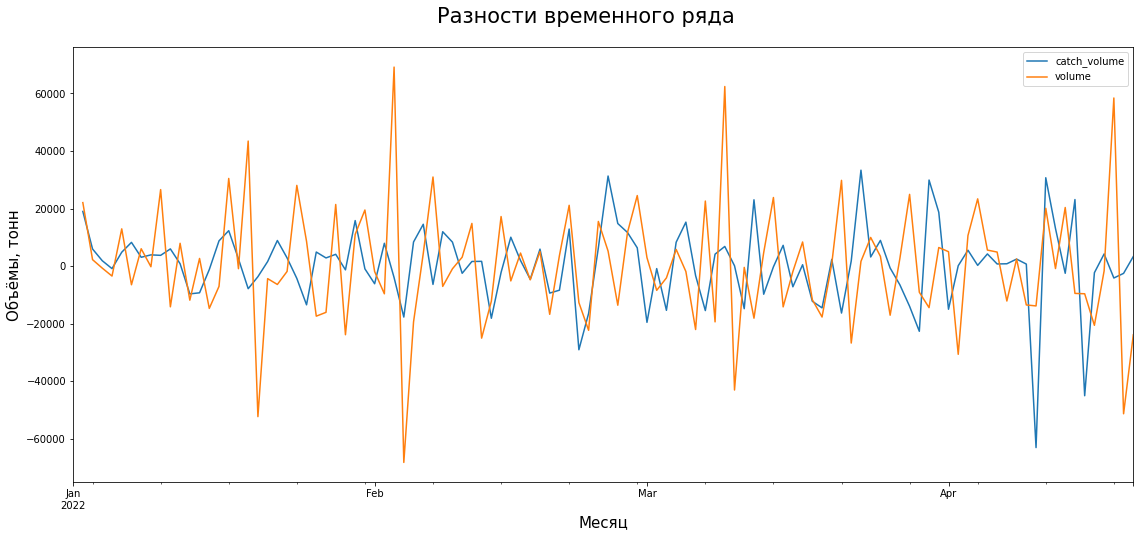

In [354]:
(db_volume - db_volume.shift().dropna()).plot(figsize=(19, 8))
plt.suptitle('Разности временного ряда', fontsize=21, y=0.95)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Объёмы, тонн', fontsize=15)
plt.show()

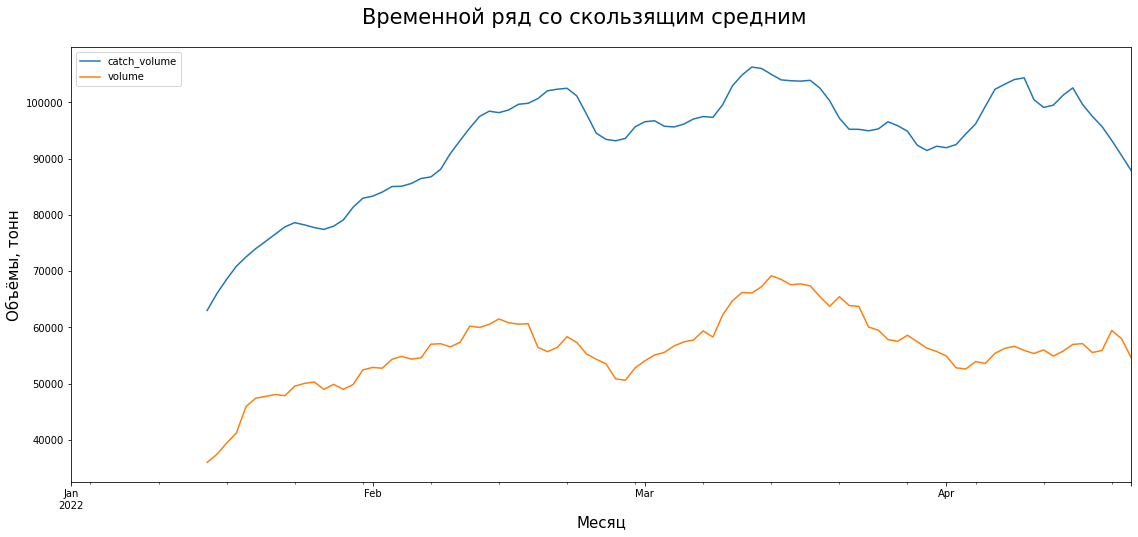

In [355]:
db_volume.rolling(15).mean().plot(figsize=(19, 8))
plt.suptitle('Временной ряд со скользящим средним', fontsize=21, y=0.95)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Объёмы, тонн', fontsize=15)
plt.show()

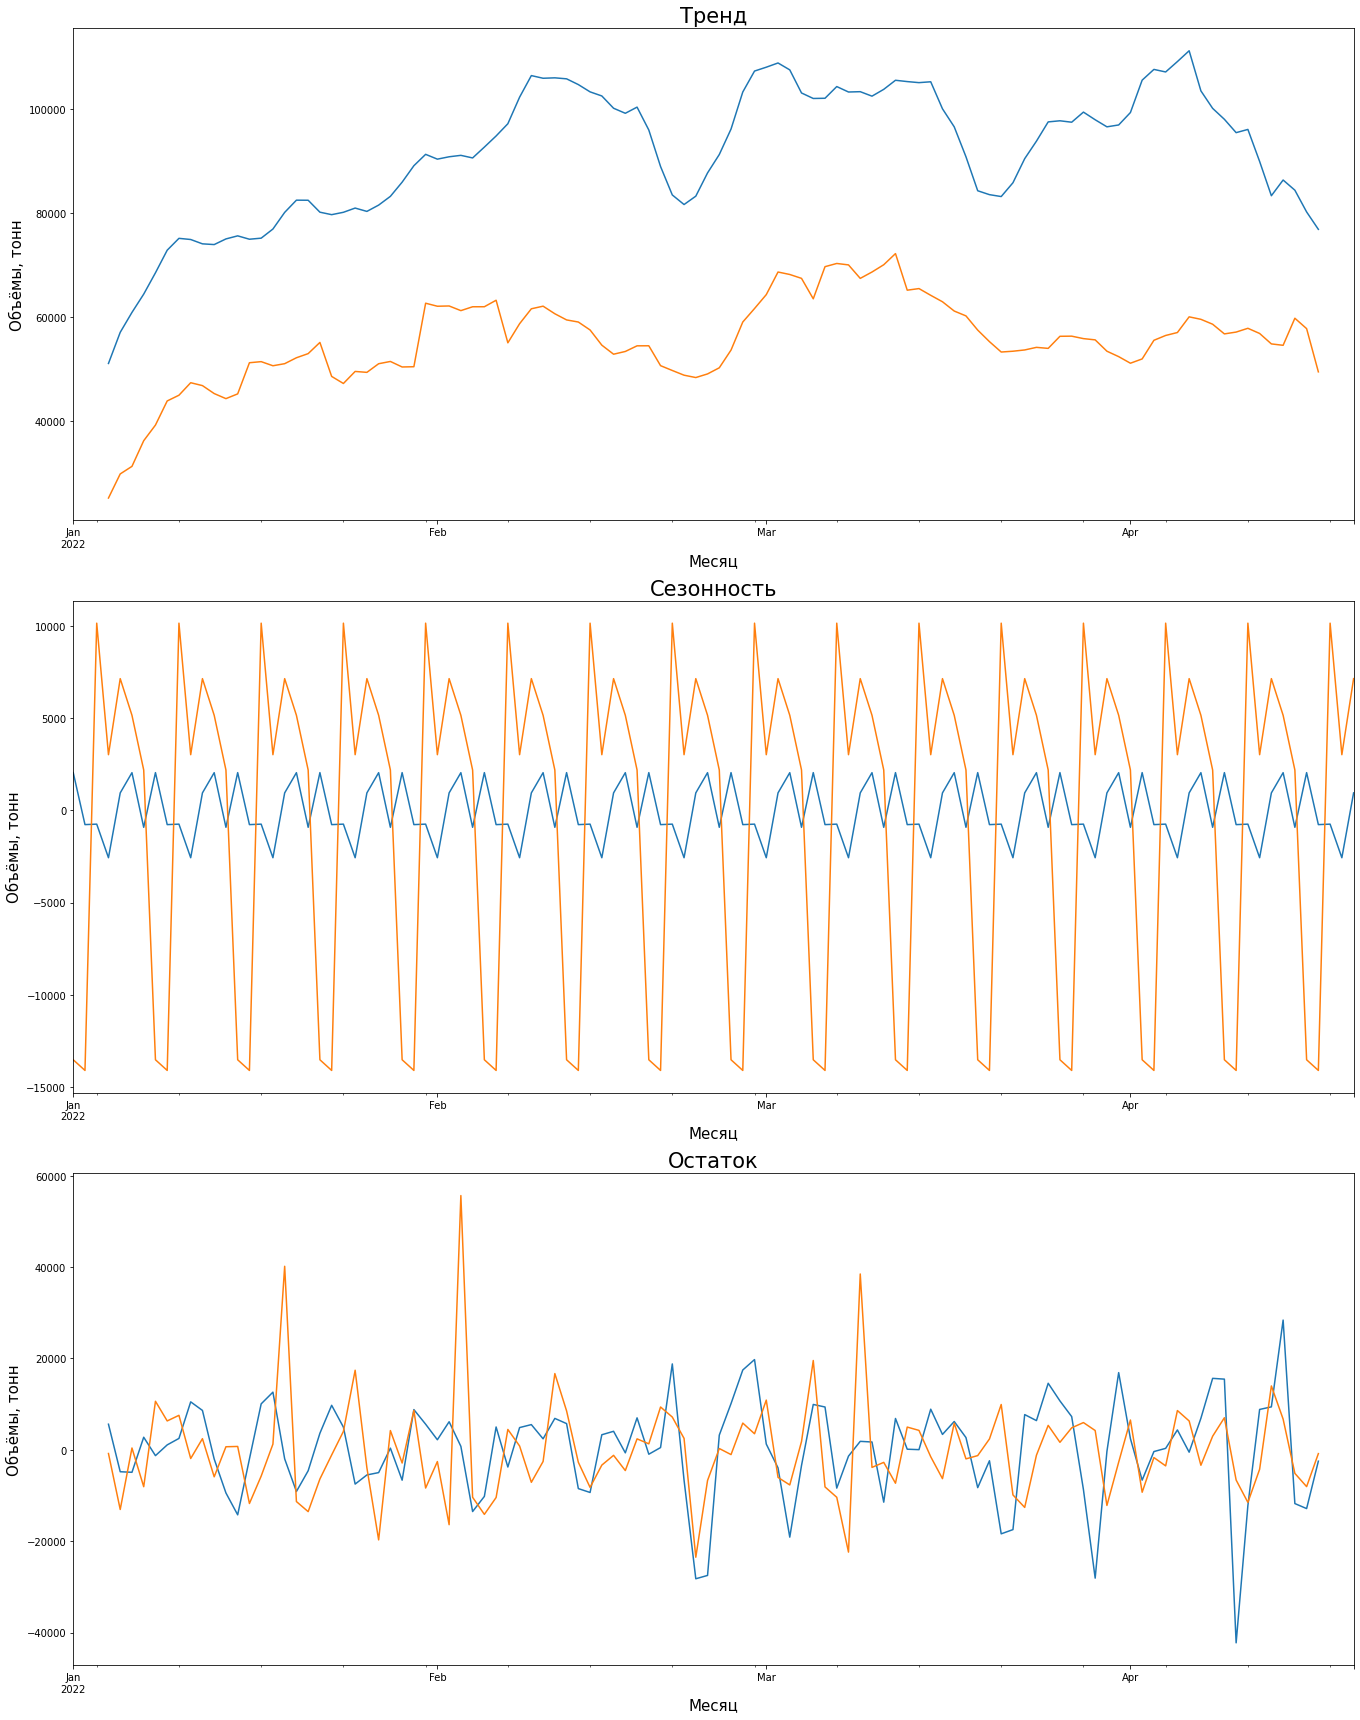

In [356]:
decomposed = seasonal_decompose(db_volume['catch_volume'])
decomposed_1 = seasonal_decompose(db_volume['volume'])

plt.figure(figsize=(19, 24))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
decomposed_1.trend.plot(ax=plt.gca())
plt.title('Тренд', fontsize=21)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Объёмы, тонн', fontsize=15)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
decomposed_1.seasonal.plot(ax=plt.gca())
plt.title('Сезонность', fontsize=21)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Объёмы, тонн', fontsize=15)


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
decomposed_1.resid.plot(ax=plt.gca())
plt.title('Остаток', fontsize=21)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Объёмы, тонн', fontsize=15)

plt.tight_layout()

Тренды более-менее совпадают, по сезонности лаг в несколько дней, по остаткам есть выбросы в сдаче продукции

In [316]:
def dbscan_evaluate(dataset):
    
    columns = dataset.select_dtypes(['int64', 'float64']).columns.tolist()
    columns.remove('id_ves')
    columns.remove('id_own')
    
    try:
        columns.remove('id_Plat')
    except ValueError:
        pass
    try:
        columns.remove('id_vsd')
    except ValueError:
        pass
    try:
        columns.remove('id_fish')
    except ValueError:
        pass
    
    column_dict = {}

    for column in columns:
        column_dict.update({column:['mean','median','min','max','sum']})

    grouped_data = dataset.groupby(['id_ves', 'id_own']).agg(column_dict)

    scaler = StandardScaler()
    X_scale = scaler.fit_transform(grouped_data)
    pca = PCA (n_components=2)

    for i_eps in range(5,18,2):
        print('DBSCAN hyperparameters: n_components = 2, eps = {}, min_samples = 3'.format(i_eps/10), end='\n\n')
        
        try:
            column_dict = {}

            for column in columns:
                column_dict.update({column:['mean','median','min','max','sum']})

            grouped_data = dataset.groupby(['id_ves', 'id_own']).agg(column_dict)

            scaler = StandardScaler()
            X_scale = scaler.fit_transform(grouped_data)    
                        
            X_reduced = pca.fit_transform(X_scale)
            pred = DBSCAN(eps=i_eps/10, min_samples=3).fit_predict(X_reduced)
            plt.figure(figsize = (15,9))
            plt.scatter(X_reduced[:,0],X_reduced[:,1], c=pred)
            plt.show()
        except ValueError:
            column_dict = {}

            for column in columns:
                column_dict.update({column:'sum'})

            grouped_data = dataset.groupby(['id_ves', 'id_own']).agg(column_dict)

            scaler = StandardScaler()
            X_scale = scaler.fit_transform(grouped_data)    
                        
            X_reduced = pca.fit_transform(X_scale)
            pred = DBSCAN(eps=i_eps/10, min_samples=3).fit_predict(X_reduced)
            plt.figure(figsize = (15,9))
            plt.scatter(X_reduced[:,0],X_reduced[:,1], c=pred)
            plt.show()

    pca = PCA (n_components=3)
    for i_eps in range(5,18,2):
        print('DBSCAN hyperparameters: n_components = 3, eps = {}, min_samples = 3'.format(i_eps/10), end='\n\n')

        X_reduced = pca.fit_transform(X_scale)
        pred = DBSCAN(eps=i_eps/10, min_samples=3).fit_predict(X_reduced)
        fig = plt.figure(figsize = (21,15))
        ax = fig.add_subplot(projection="3d")
        x,y,z = [X_reduced[:,i] for i in range(3)]
        ax.scatter(x,y,z, c=pred)
        plt.show()

C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


DBSCAN hyperparameters: n_components = 2, eps = 0.5, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


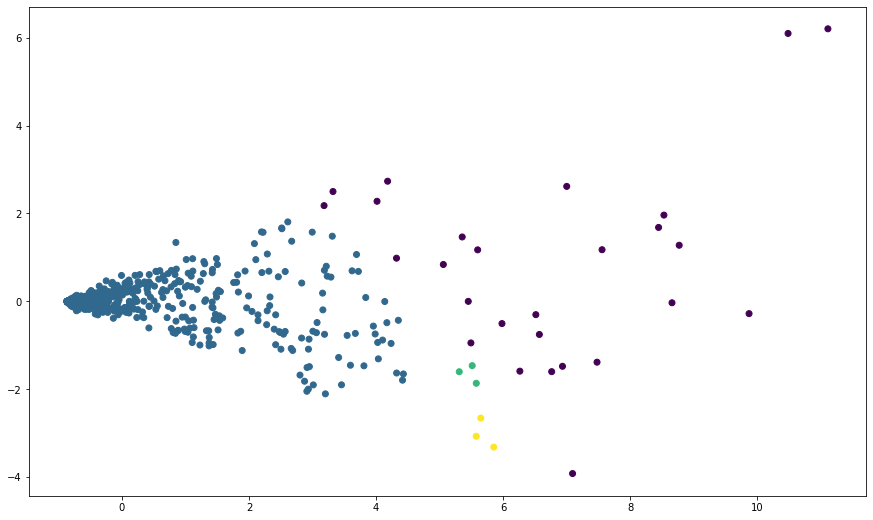

DBSCAN hyperparameters: n_components = 2, eps = 0.7, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


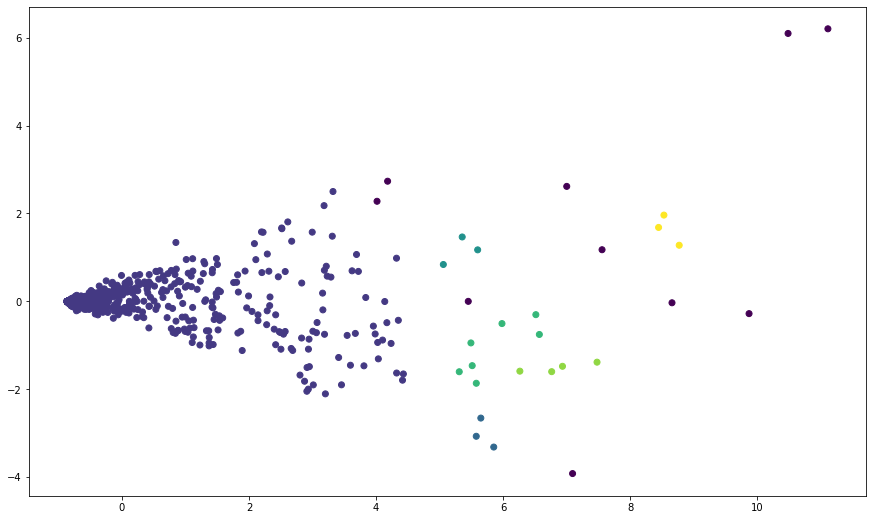

DBSCAN hyperparameters: n_components = 2, eps = 0.9, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


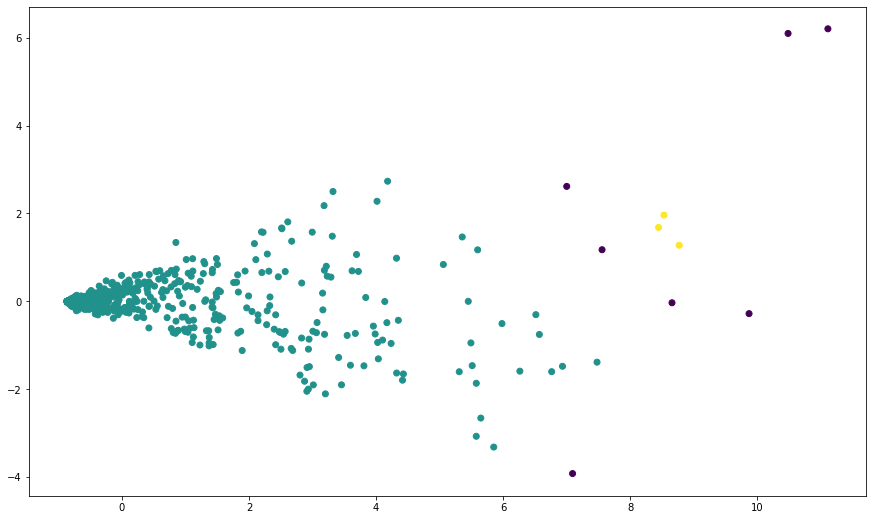

DBSCAN hyperparameters: n_components = 2, eps = 1.1, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


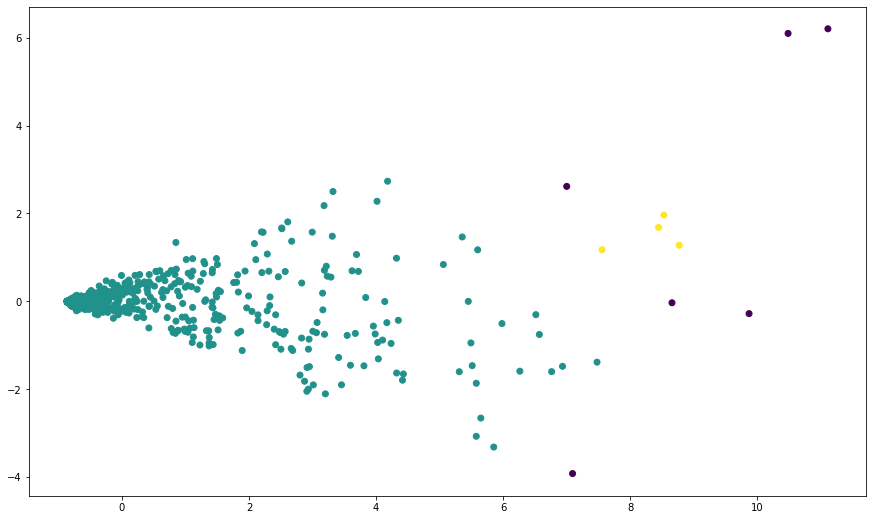

DBSCAN hyperparameters: n_components = 2, eps = 1.3, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


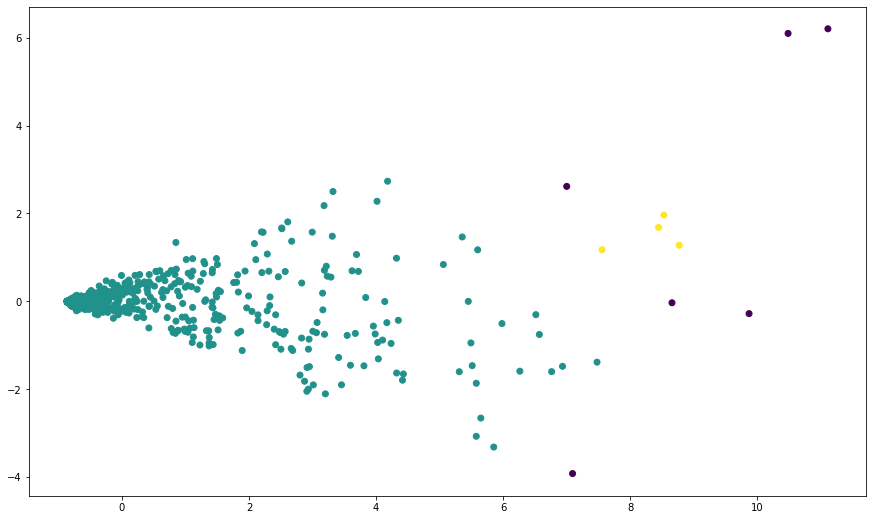

DBSCAN hyperparameters: n_components = 2, eps = 1.5, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


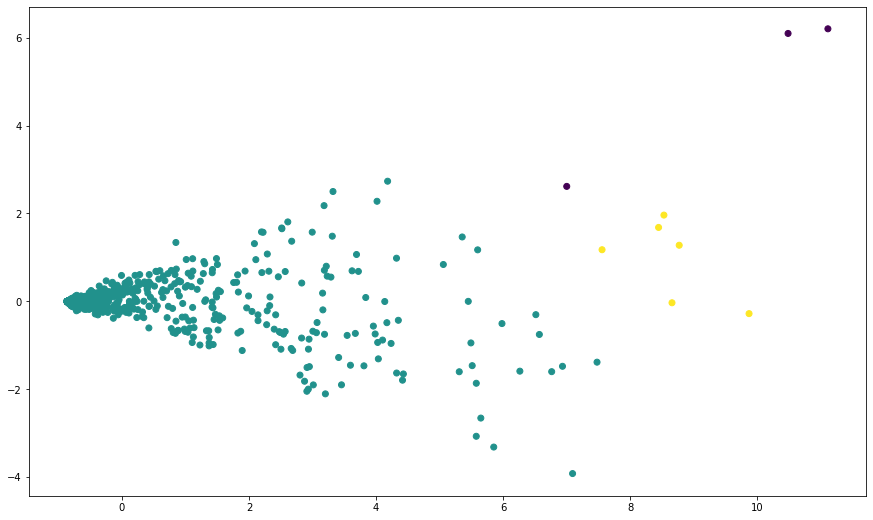

DBSCAN hyperparameters: n_components = 2, eps = 1.7, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


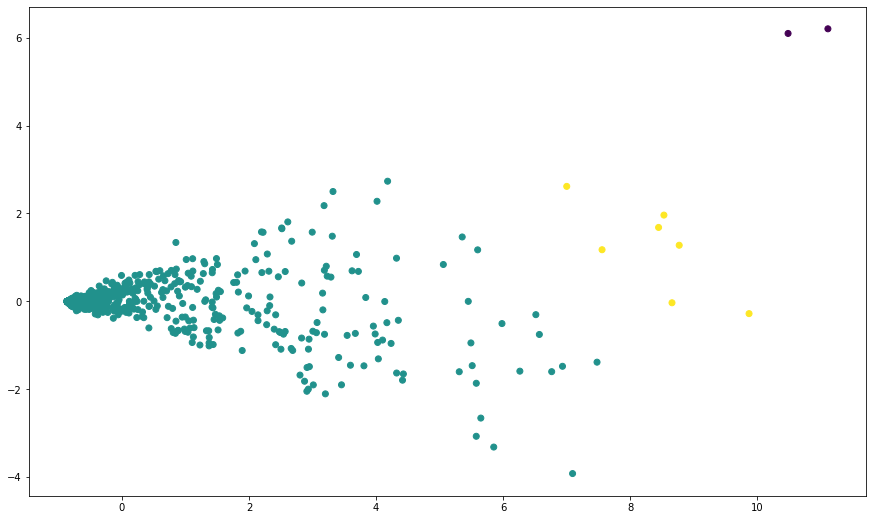

DBSCAN hyperparameters: n_components = 3, eps = 0.5, min_samples = 3



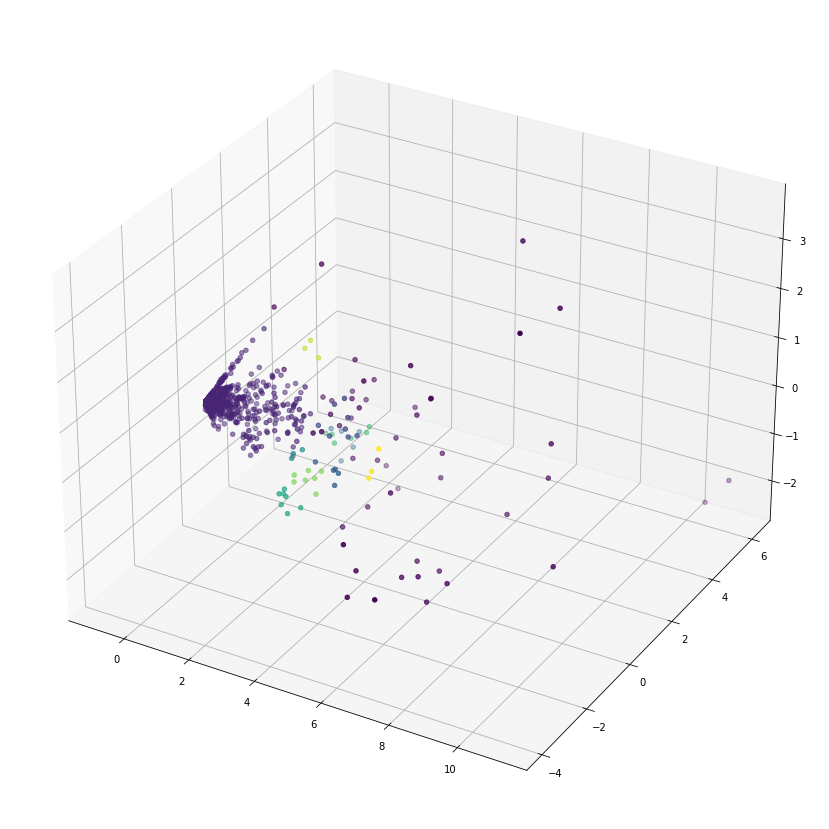

DBSCAN hyperparameters: n_components = 3, eps = 0.7, min_samples = 3



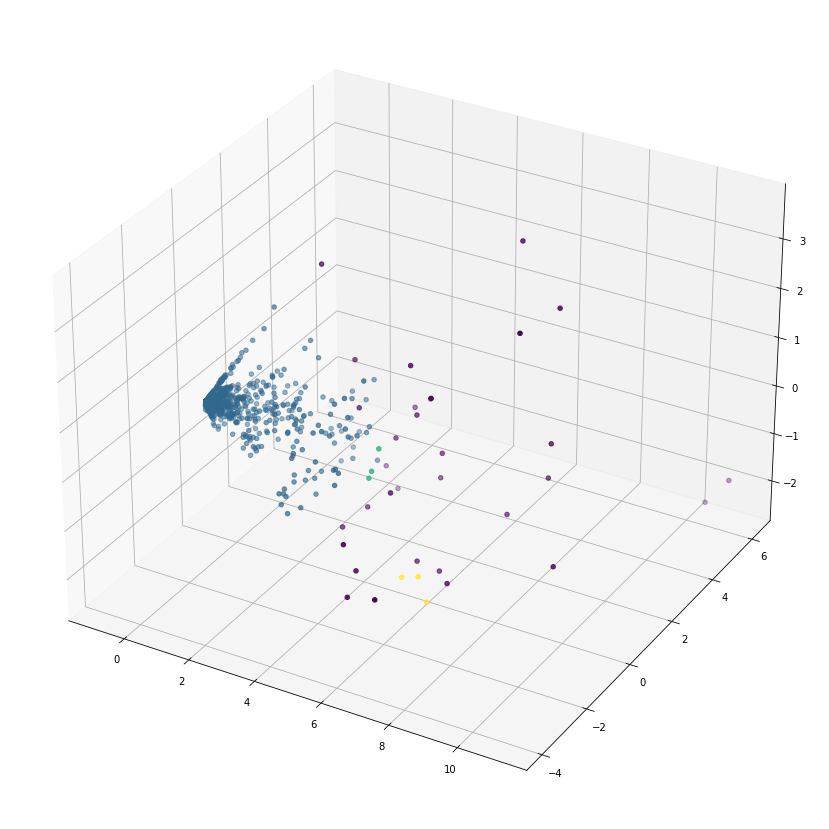

DBSCAN hyperparameters: n_components = 3, eps = 0.9, min_samples = 3



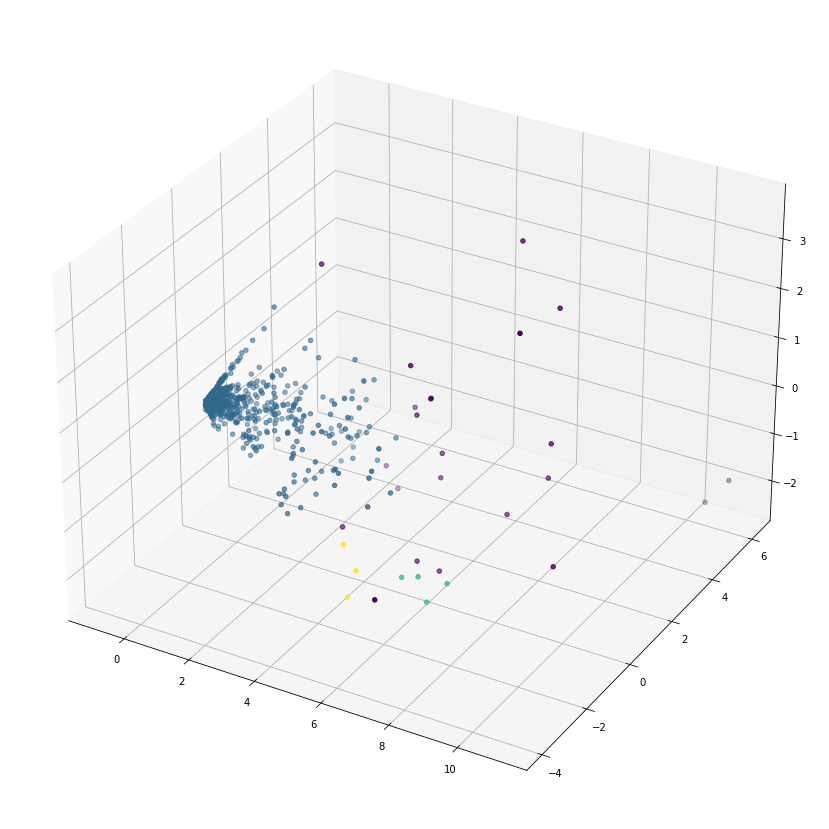

DBSCAN hyperparameters: n_components = 3, eps = 1.1, min_samples = 3



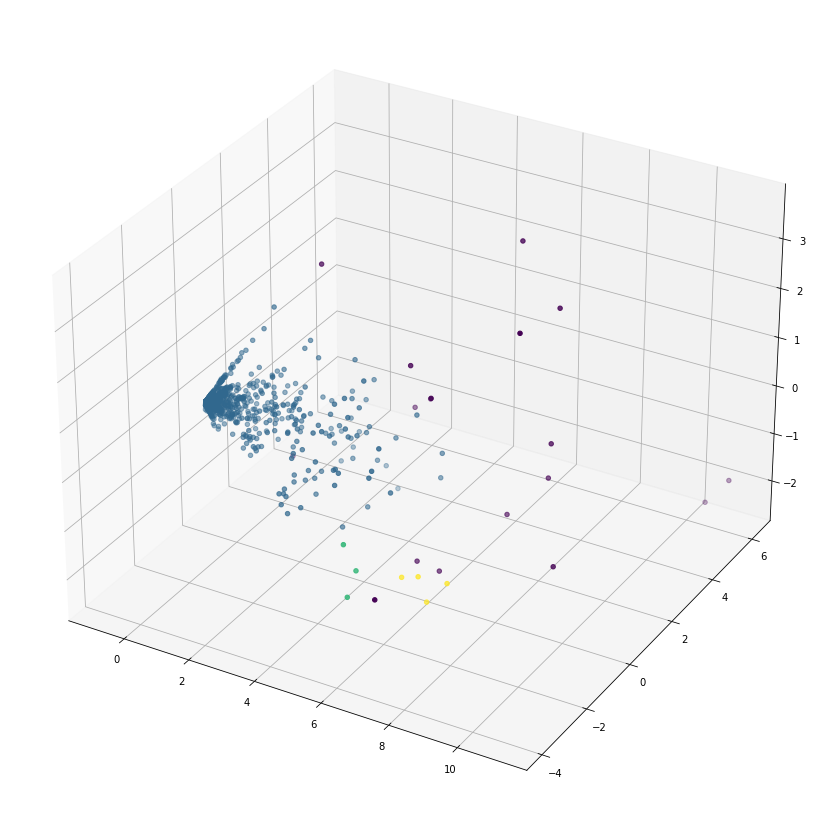

DBSCAN hyperparameters: n_components = 3, eps = 1.3, min_samples = 3



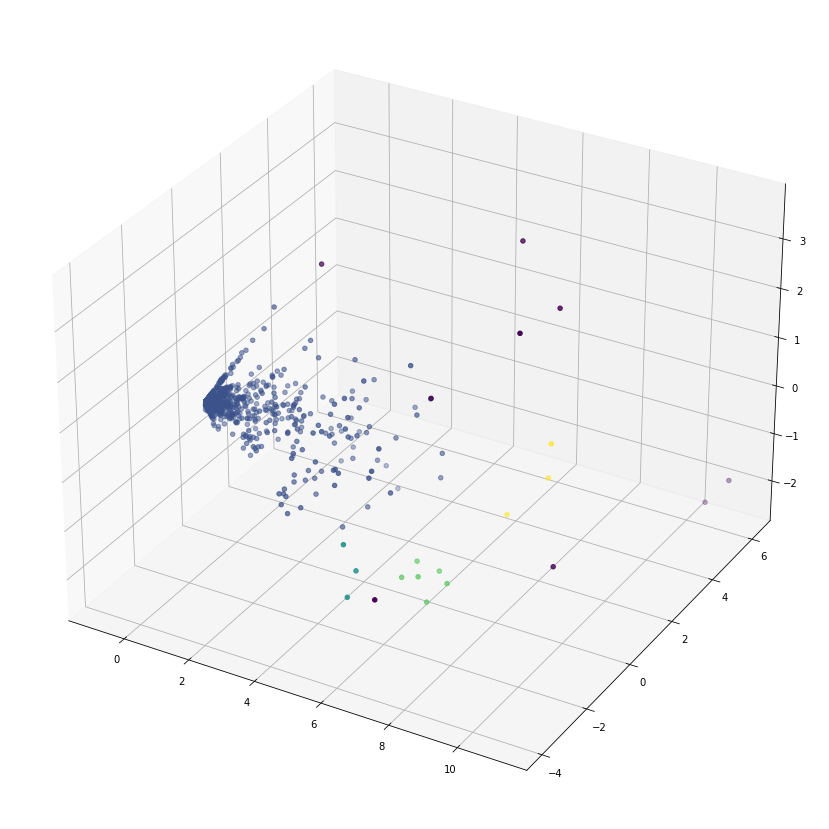

DBSCAN hyperparameters: n_components = 3, eps = 1.5, min_samples = 3



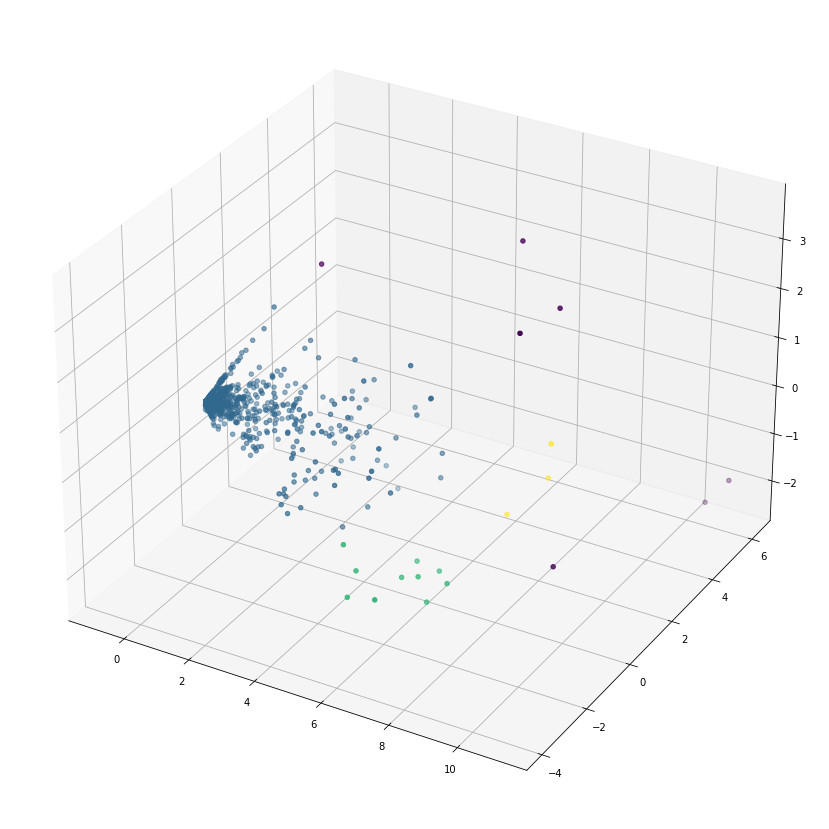

DBSCAN hyperparameters: n_components = 3, eps = 1.7, min_samples = 3



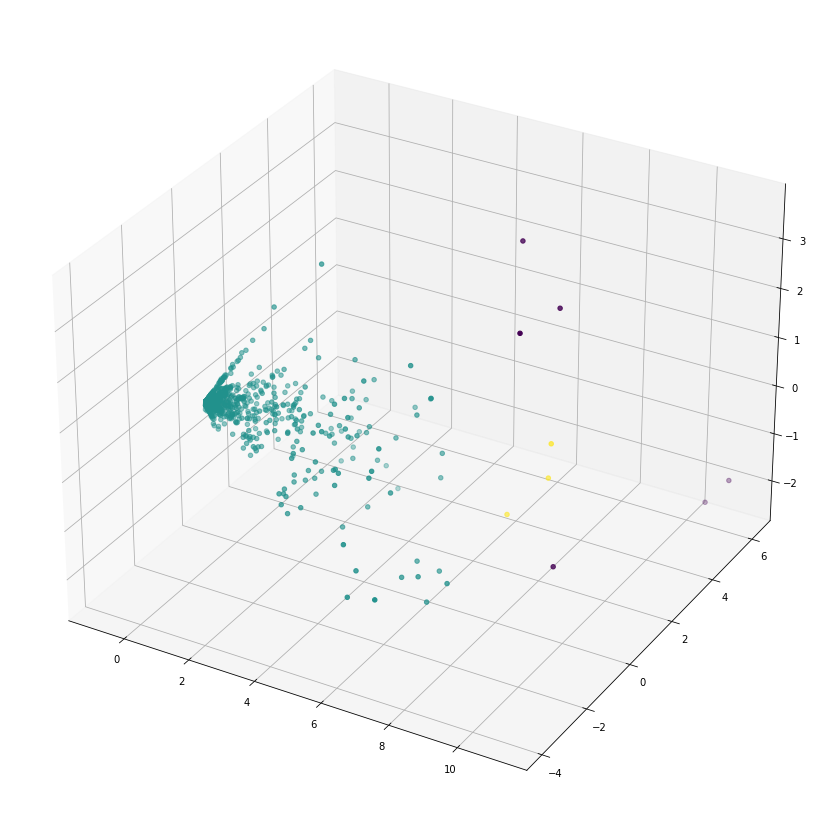

DBSCAN hyperparameters: n_components = 2, eps = 0.5, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tu

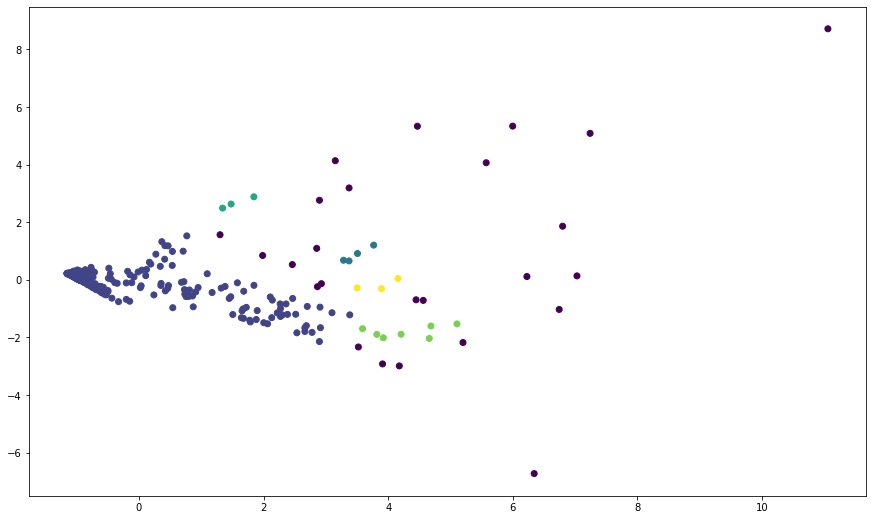

C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


DBSCAN hyperparameters: n_components = 2, eps = 0.7, min_samples = 3



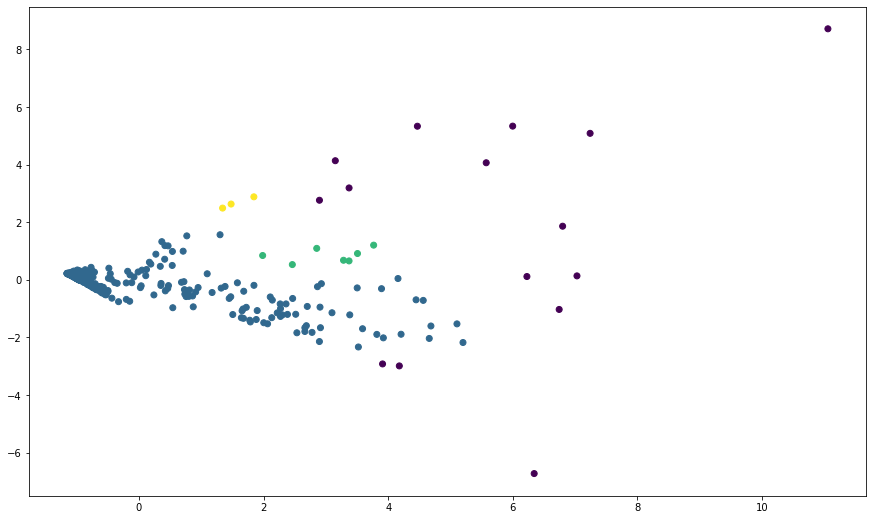

DBSCAN hyperparameters: n_components = 2, eps = 0.9, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


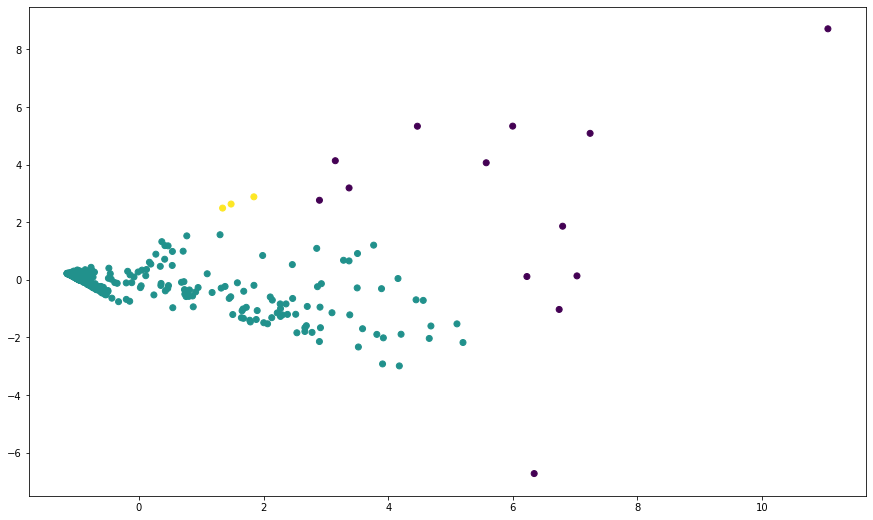

DBSCAN hyperparameters: n_components = 2, eps = 1.1, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


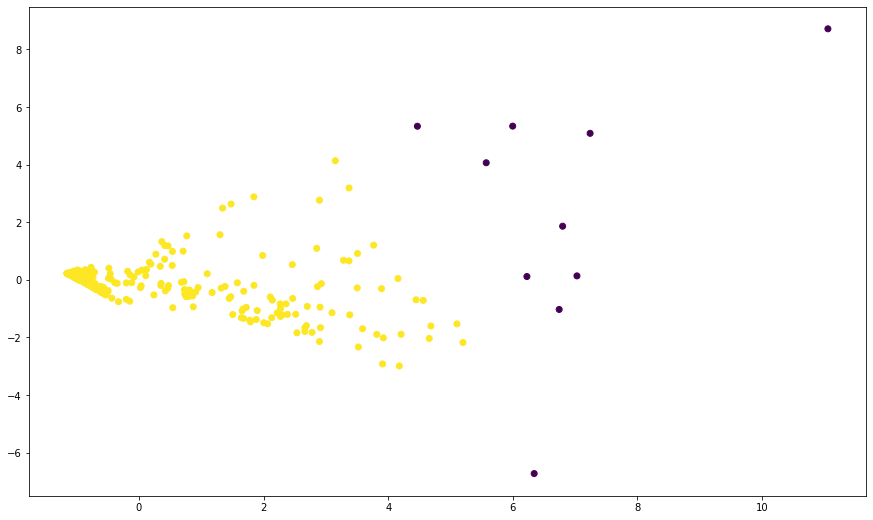

DBSCAN hyperparameters: n_components = 2, eps = 1.3, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


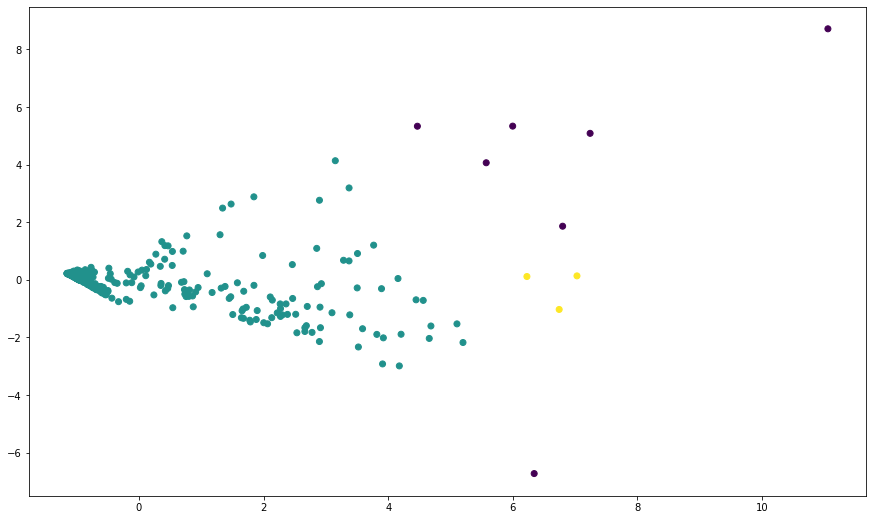

DBSCAN hyperparameters: n_components = 2, eps = 1.5, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


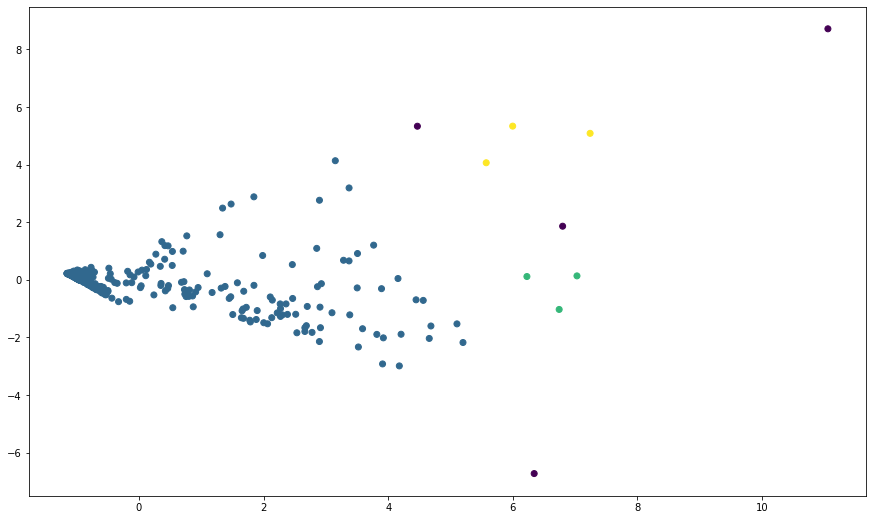

DBSCAN hyperparameters: n_components = 2, eps = 1.7, min_samples = 3



C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


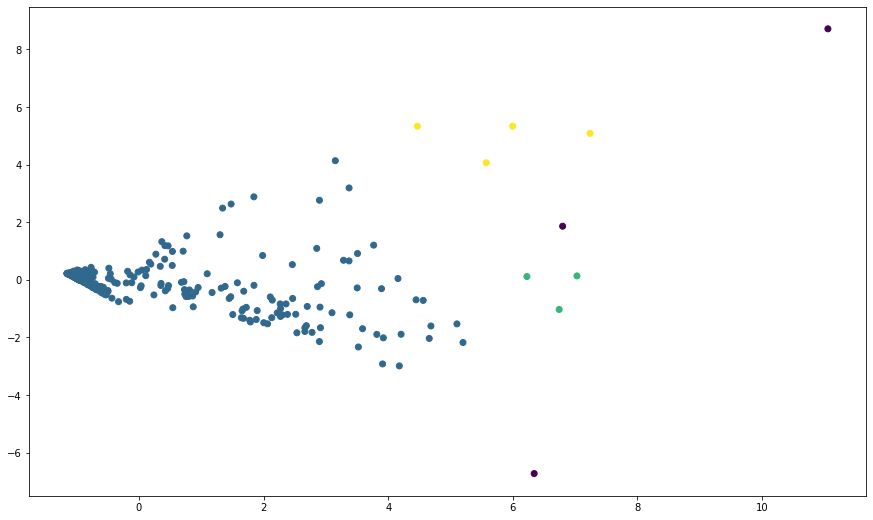

DBSCAN hyperparameters: n_components = 3, eps = 0.5, min_samples = 3



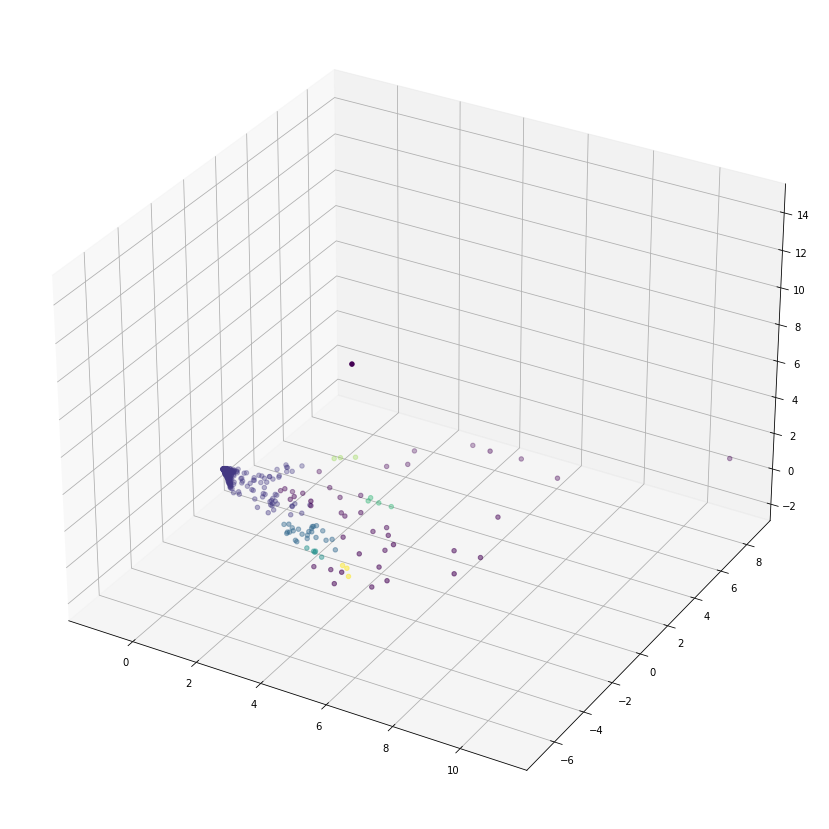

DBSCAN hyperparameters: n_components = 3, eps = 0.7, min_samples = 3



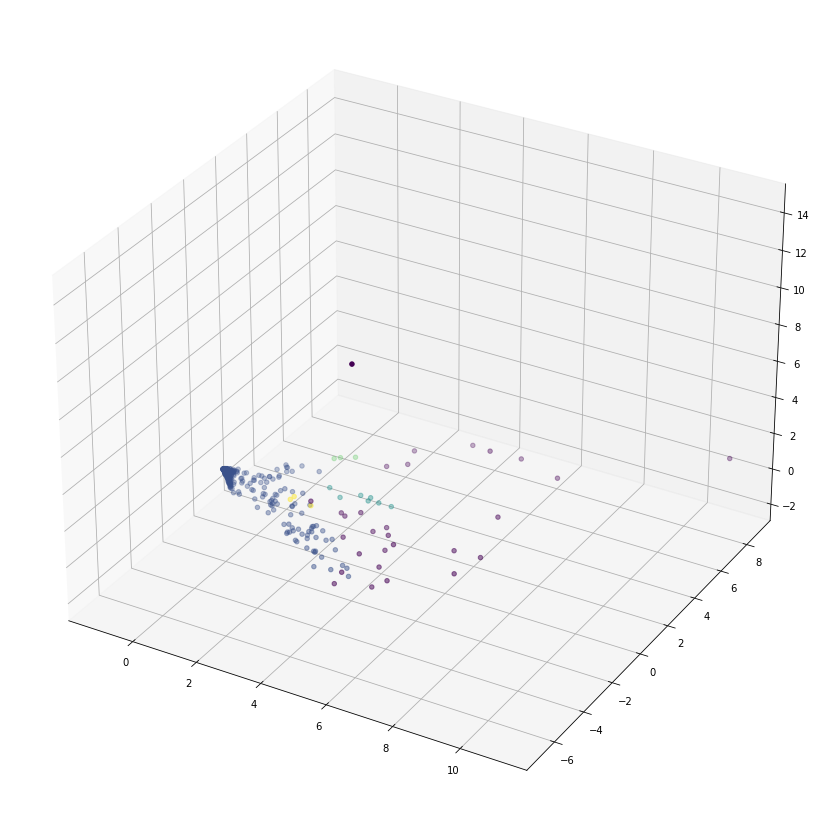

DBSCAN hyperparameters: n_components = 3, eps = 0.9, min_samples = 3



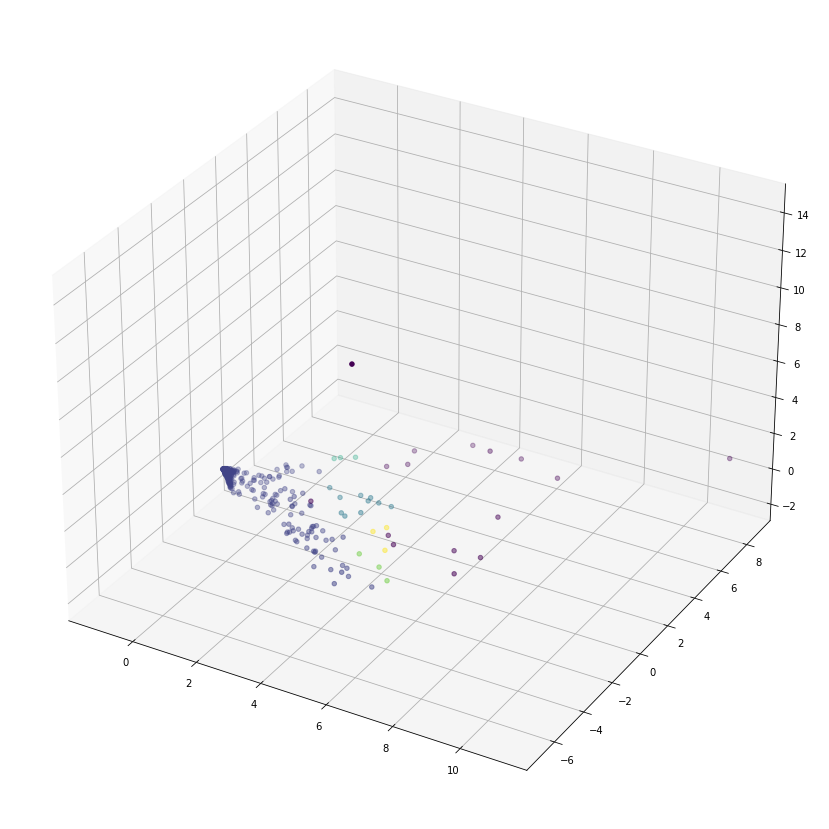

DBSCAN hyperparameters: n_components = 3, eps = 1.1, min_samples = 3



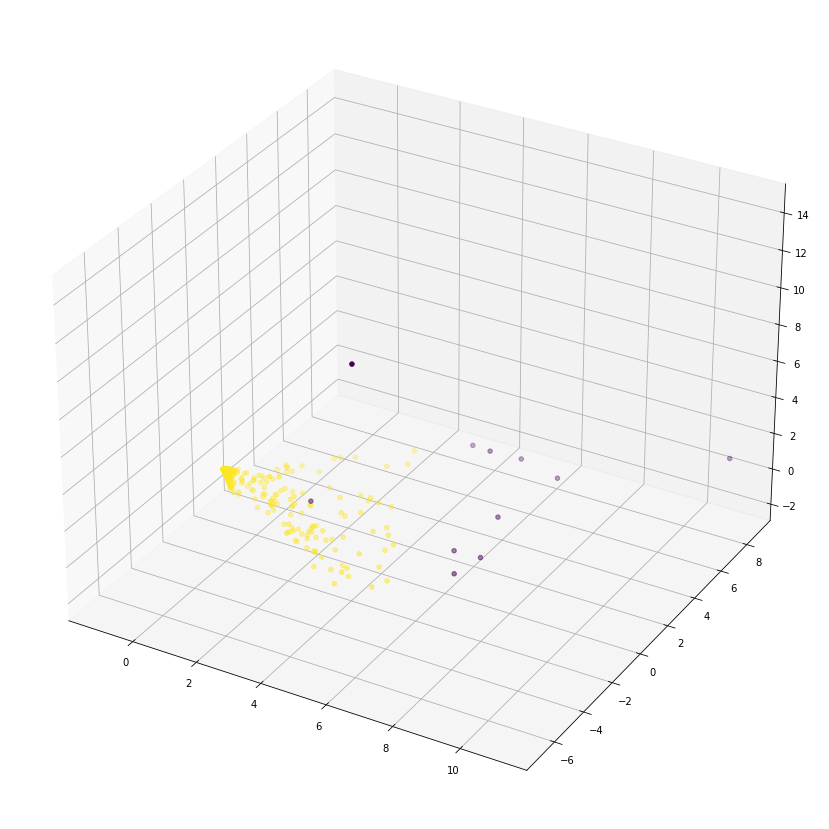

DBSCAN hyperparameters: n_components = 3, eps = 1.3, min_samples = 3



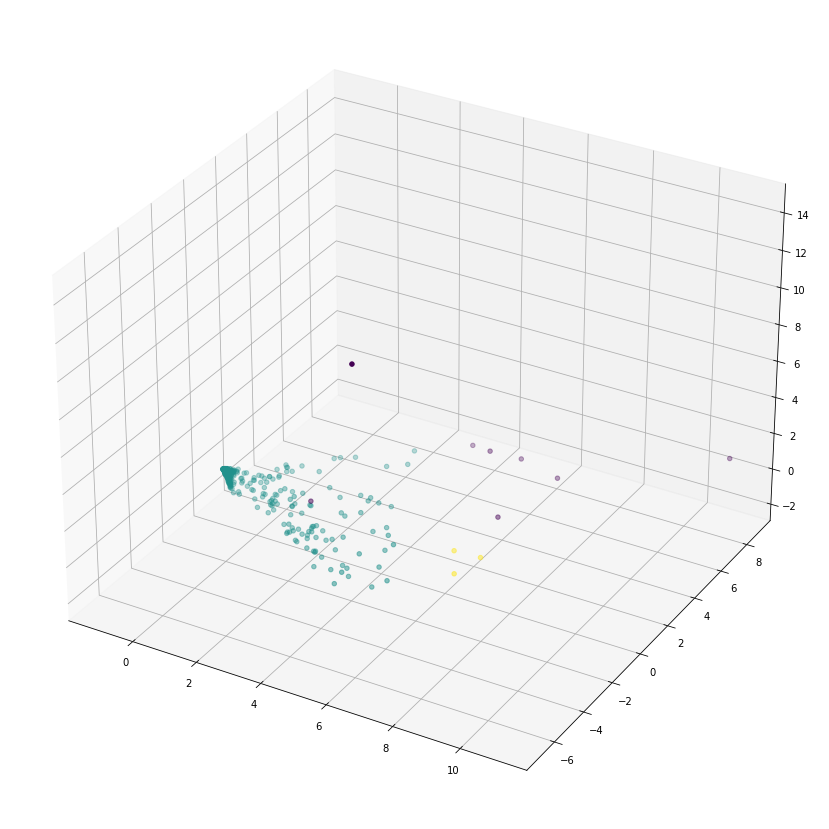

DBSCAN hyperparameters: n_components = 3, eps = 1.5, min_samples = 3



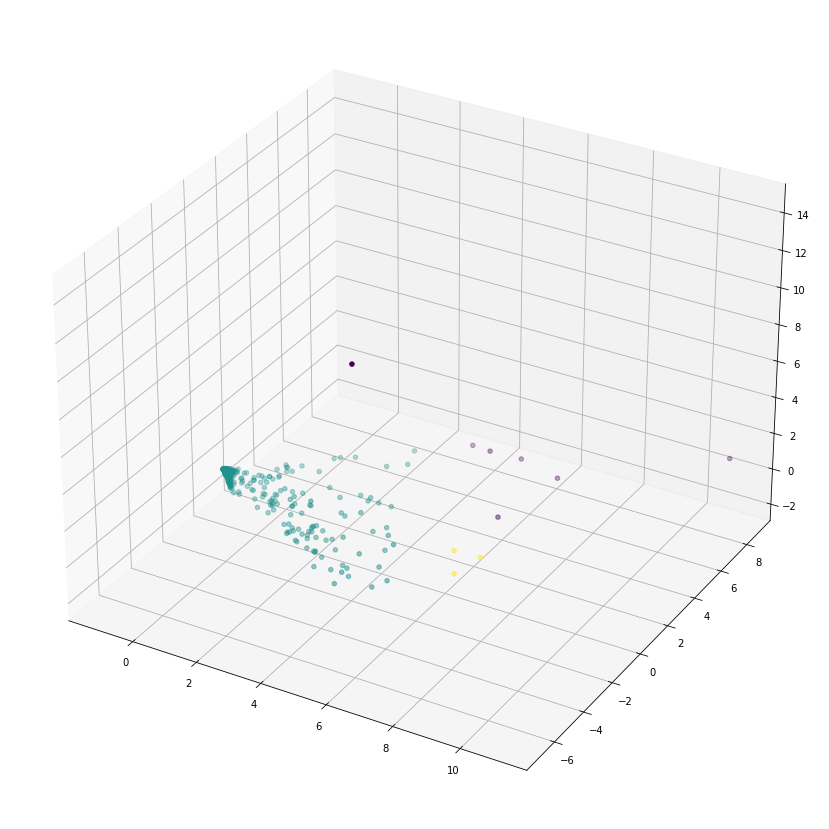

DBSCAN hyperparameters: n_components = 3, eps = 1.7, min_samples = 3



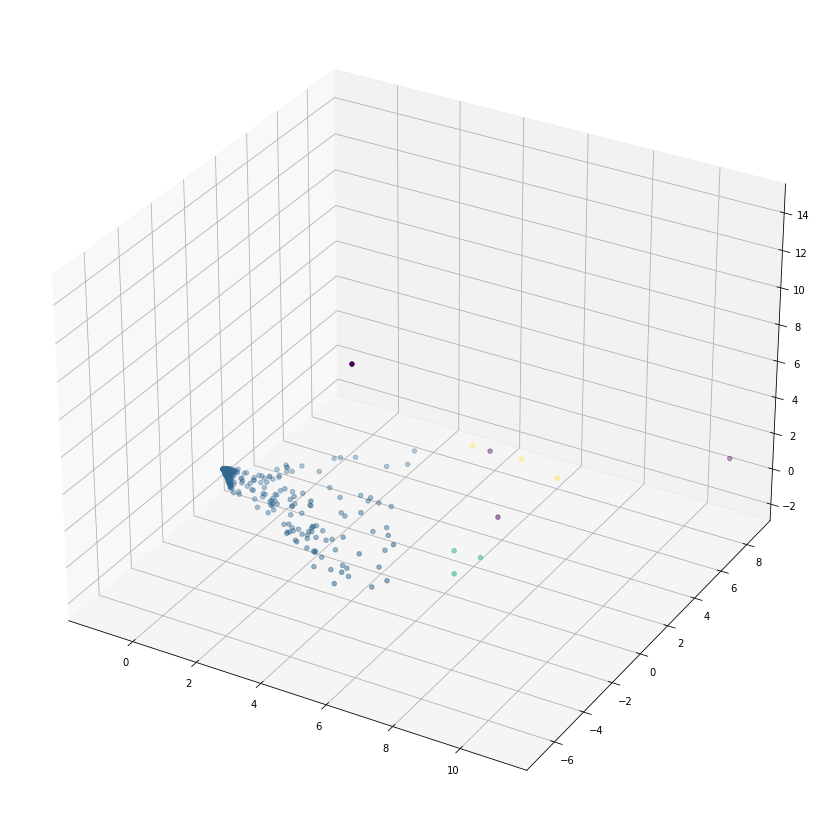

In [318]:
dbscan_evaluate(db1_main)
dbscan_evaluate(db2_main)

In [376]:
model_svm = OneClassSVM(kernel='rbf', gamma= 0.001, nu= 0.05)
model_svm.fit(db_volume)
y_pred = model_svm.predict(db_volume)
anomaly_values = db_volume.iloc[np.where(y_pred == -1)]
print(anomaly_values)

            catch_volume     volume
2022-01-01  27319.403300   3783.214
2022-01-02  46301.152939  25837.339
2022-01-03  52227.150061  28056.001
2022-01-04  54072.087132  27328.327
2022-01-05  53176.975097  23842.402
...                  ...        ...
2022-04-16  69393.512058  36157.785
2022-04-17  73600.276301  34487.173
2022-04-18  69441.858393  92919.220
2022-04-19  66896.674001  41553.760
2022-04-20  70213.139316  17666.260

[88 rows x 2 columns]


In [358]:
plt.scatter

(110, 2)

In [ ]:
iso_forest = IsolationForest(n_estimators=100, max_features=100)
iso_forest.fit(x_train)

In [ ]:
db1_main.

### <font color='lightblue'>=====================================================================================================

In [370]:
db2_main.shape

(3205586, 8)